In [1]:
import json
import logging
import os
import sys
import urllib
import warnings
from datetime import datetime, date

import pandas as pd
from sqlalchemy import create_engine, text
import json 


### Prepare the data for Band Analysis (RedZoneV2-based vs. Anson's IBV Score-based)

#### Imoport the data with decoded model output JSON

In [3]:
# import the data and try to parse the JSON output
server = '192.168.1.15'
username = 'Junchen'
password = '9DFXjhhlR3k5'
database = 'BankuityPostOnboarding'

params = urllib.parse.quote_plus(
    "DRIVER={ODBC Driver 18 for SQL Server};"
    f"SERVER={server},1433;DATABASE={database};UID={username};PWD={password};"
    "Encrypt=yes;TrustServerCertificate=yes;"
)
engine = create_engine(f"mssql+pyodbc:///?odbc_connect={params}")

cnxn = engine.connect()

query1 = f""" 
SELECT *,
          CONVERT(VARCHAR(MAX),
                  DECOMPRESS(ResponseJSON)
         ) AS ResponseJSONText
FROM BankuityPostOnboarding.dbo.SpeedyAnalysis
WHERE ExperimentName = 'loonie_rerun_V3';
"""

df_rerun = pd.read_sql(query1, cnxn)

In [4]:
print(df_rerun.shape)

(11474, 11)


#### Write the ResponseJSONText to Local (CAREFULL TO RUN!!!!!!!)


In [ ]:
""" output_dir = "/Users/starsrain/nov2025_concord/loonie_bankuity_rerun/rerun_output_JSONs_V3"
os.makedirs(output_dir, exist_ok=True)

for token, response_text in zip(df_rerun.IBVToken.values, df_rerun.ResponseJSONText.values):
    try:
        data = json.loads(response_text) if isinstance(response_text, str) else response_text
        filename = os.path.join(output_dir, f"ModelResponse_{token}.json")
        with open(filename, 'w', encoding='utf-8') as f:
            json.dump(data, f, indent=4, separators=(',', ': '), ensure_ascii=False)
    except Exception as e:
        print(token, e) """

#### Extract the RedZoneV2 RiskScore from the JSONs

In [2]:
import re

input_dir = "/Users/starsrain/nov2025_concord/loonie_bankuity_rerun/rerun_output_JSONs_V3"
rows = []

for filename in os.listdir(input_dir):
    if not filename.endswith(".json"):
        continue
    match = re.search(r"_(\d+)\.json$", filename)
    if not match:
        continue
    ibv_status_id = int(match.group(1))
    file_path = os.path.join(input_dir, filename)
    try:
        with open(file_path, "r", encoding="utf-8") as f:
            payload = json.load(f)
        customer = (payload or {}).get("customerInfo") or {}
        scores = customer.get("scores", {})
        redzone = scores.get("redZoneV2", {})
        model_score = redzone.get("modelScore")
        risk_score = None
        if isinstance(model_score, list) and model_score:
            first = model_score[0] if isinstance(model_score[0], dict) else None
            risk_score = first.get("riskScore") if first else None
        elif isinstance(model_score, dict):
            risk_score = model_score.get("riskScore")
        rows.append({"IBVStatusID": ibv_status_id, "redZoneV2_score": risk_score})
    except Exception as e:
        rows.append({"IBVStatusID": ibv_status_id, "redZoneV2_score": None})


df_redzone_scores = pd.DataFrame(rows).sort_values("IBVStatusID").reset_index(drop=True)

print(df_redzone_scores.head(10))
print(df_redzone_scores.shape)


   IBVStatusID  redZoneV2_score
0          757       145.000000
1         1258       162.000000
2         1382        78.979465
3         1810       298.000000
4         2334        94.987807
5         3158       224.000000
6         3509       216.000000
7         3513        61.982032
8         3586       154.000000
9         3854       146.000000
(11474, 2)


### Get the metrics dataframe

In [3]:
from sqlalchemy import create_engine 
import urllib
server = '192.168.1.15'
username = 'Junchen'
password = '9DFXjhhlR3k5'
database = 'LF_LMSMaster'

params = urllib.parse.quote_plus(
    "DRIVER={ODBC Driver 18 for SQL Server};"
    f"SERVER={server},1433;DATABASE={database};UID={username};PWD={password};"
    "Encrypt=yes;TrustServerCertificate=yes;"
)
engine = create_engine('mssql+pyodbc:///?odbc_connect=%s' % params)


cnxn = engine.connect()
query1 = """ 
DROP TABLE IF EXISTS #t1;
SELECT
    ibv.IBVStatusID,
    ibv.DateCreated AS IBVStatus_DateCreated,
    A.Application_ID, A.ApplicationSteps, A.PortfolioID, A.CustomerID, A.CustomerSSN, A.ApplicationDate, A.Score, CustEmail,
    CASE WHEN ApplicationSteps LIKE '%S%' THEN 1 ELSE 0 END AS NewlyScored,
    CASE WHEN A.ApplicationStatus IN ('A','P') THEN 1 ELSE 0 END AS Accepted,
    CASE WHEN A.ApplicationStatus IN ('A','P') THEN A.LeadPurchasePrice ELSE 0 END AS LeadPurchasePrice,
    CASE WHEN L.LoanStatus NOT IN ('V','W','G','K') AND A.ApplicationStatus='J' THEN 1 ELSE 0 END AS PartialPreApproved,
    CASE WHEN L.LoanStatus NOT IN ('V','W','G','K') THEN 1 ELSE 0 END AS Originated,
    L.LoanID,
    DATEDIFF(YEAR, VW.DOB, A.ApplicationDate) AS Age,
    CASE WHEN VW.Frequency IN ('B','S') THEN 'B' ELSE VW.Frequency END AS Frequency,
    CASE WHEN L.LoanStatus NOT IN ('V','W','G','K') THEN L.OriginatedAmount ELSE NULL END AS OriginatedAmount,
    OriginationDate,
    LoanStatus,
    CASE WHEN ((L.RenewalLoanId <> '0') OR (A.LPCampaign = 'RENEW')) THEN 'RENEWAL'
         WHEN ApplicationSteps NOT LIKE '%R%' THEN 'NEW'
         ELSE 'REPEAT' END AS CustType,
    RenewalLoanId
INTO #t1
FROM Application A
LEFT JOIN Loans L
  ON A.Application_ID = L.ApplicationID AND A.PortFolioID = L.PortFolioID
LEFT JOIN LF_LMS_Logs..VW_ApplicationDump VW
  ON A.APPGUID = VW.APPGUID

OUTER APPLY (
  SELECT TOP 1 s.IBVStatusID, s.DateCreated
  FROM [LF_BankData].[dbo].[IBVStatus] s
  WHERE s.AccountNumber = A.CustomerSSN
    AND s.PortfolioID   = A.PortfolioID
  ORDER BY ABS(DATEDIFF_BIG(SECOND, s.DateCreated, A.ApplicationDate)) ASC,
           s.DateCreated DESC, s.IBVStatusID DESC
) ibv

where A.ApplicationDate>='2025-04-25' and ((CustEmail is null) or  (CustEmail not in ( 'josh@concordadvice.com', 'tiffany.speedyservicing@gmail.com','bobby@speedyservicing.com',
'and.kom@example.com', 'and.tor020@example.com', 'and.tor050@example.com', 'and.torrc4@example.com',
'test@dot818.com', 'test@example.com', 'test@gmail.com', 'test@loanscanada.ca', 'test@test.com', 'test2@test.com',
'testerqad@gmail.com', 'testik@test.com', 'testteam@dmaassociatescorp.com', 'tiffany.speedyservicing@gmail.com')))




UPDATE #t1 -- update the renewal loanid from 0 to correct previous loanIDs
SET #t1.RenewalLoanId = B.RenewalLoanId
from #t1 A inner join (select * from
(select A.LoanID, L.LoanID as RenewalLoanId, row_number() over (partition by A.LoanID order by datediff(day, L.OriginationDate, A.OriginationDate) desc) as RN from #t1 A
inner join Application A2 on A.CustomerID = A2.CustomerID and A2.ApplicationDate < A.ApplicationDate
inner join Loans L on A2.Application_ID = L.ApplicationID and A2.PortFolioID = L.PortFolioID and L.OriginationDate < A.OriginationDate and L.LoanStatus not in ('W','V','G','K')
where A.CustType = 'RENEWAL' and A.RenewalLoanId = '0') K where RN=1) B on A.LoanID = B.LoanID



-- scoring result for PlaidUDW_v1 and NegativeDBModelLP_v1
drop table if EXISTS #t2
select *
into #t2 from
(select A.*, B1.ExtResponse as B1ExtResponse, B2.ExtResponse as B2ExtResponse,
NDScore, IBVScore, NDBand,IBVBand,
row_number() over (partition by A.Application_ID, A.PortfolioID order by case when B2.ExtResponse is not null and B1.ExtResponse <> '' then 1 else 0 end desc,B.ApplicationDate desc) as RN
from #t1 A
left join Application B on A.CustomerID = B.CustomerID and A.ApplicationDate >= B.ApplicationDate AND B.ApplicationSteps like '%S%'
left join ScoringPythonResult B1 CROSS APPLY OPENJSON(B1.ExtResponse) WITH (IBVScore int '$.ModelScore', IBVBand int '$.IBVBand')  on B.Application_ID = B1.ApplicationID and B.PortFolioID = B1.PortfolioID and B1.iLabel= 'IBVBand'
left join ScoringPythonResult B2 CROSS APPLY OPENJSON(B2.ExtResponse) WITH (NDScore int '$.ModelScore', NDBand int '$.NDBand') on B.Application_ID = B2.ApplicationID and B.PortFolioID = B2.PortfolioID and B2.iLabel= 'NDBand' ) K where RN=1


ALTER TABLE #t2
DROP COLUMN RN;


-- Originated -- FPDFA rate:
-- go through the payments for First Installment First Attempt whose due date was before today and payment status not in V:Voided/P:Pending/T:3rd party
-- payment Mode: not in ('V' VIP,'P' promotion ,'T' rebate,'H' manual rebate,'G' charges)
DROP TABLE IF EXISTS #LF_LoanDefault
SELECT L.LoanID, L.Application_ID AS Application_ID, A.APPGUID, A.ApplicationDate, A.ApplicationSteps, L.PortFolioID, L.LoanStatus,
P.InstallmentNumber, P.PaymentStatus, P.PaymentType, P.PaymentMode, P.AttemptNo, P.TransactionDate, P.PaymentID,
I.InstallmentID, I.iPaymentMode, I.DueDate, I.Status, -- used to exclude pendings (code 684)
(CASE WHEN I.Status=684 THEN 1 ELSE 0 END) AS Pending
INTO #LF_LoanDefault
FROM #t2 L
LEFT JOIN LF_LMSMaster..Payment P ON P.LoanID = L.LoanID
LEFT JOIN LF_LMSMaster..Installments I ON I.InstallmentID = P.InstallmentID
LEFT JOIN LF_LMSMaster..Application A ON A.PortfolioID=L.PortfolioID AND A.Application_ID = L.Application_ID
WHERE I.InstallmentNumber = 1;

DROP TABLE IF EXISTS #LoanDefault_Flag
SELECT 
    L.*,
    -- FPDFA flag
    CASE 
        WHEN L.PaymentStatus = 'R'
             AND L.PaymentType IN ('I','S','A')
             AND L.PaymentMode IN ('A','B','D')
             AND L.DueDate <= CAST(GETDATE() AS date)
             AND NOT EXISTS (
                 SELECT 1
                 FROM #LF_LoanDefault ld
                 WHERE ld.InstallmentID = L.InstallmentID
                   AND ld.PaymentStatus = 'D'
                   AND ld.PaymentType NOT IN ('3','~','Q')
                   AND ld.PaymentMode IN ('A','D','B')
                   AND CONVERT(date, ld.TransactionDate) = CONVERT(date, L.DueDate)
             )
        THEN 1 ELSE 0 END AS is_FPDFA,
        CASE 
        WHEN L.LoanStatus NOT IN ('V','W','G','K')
             AND NOT (
                 L.iPaymentMode = 144 
                 AND L.Pending = 1
                 AND L.DueDate >= CAST(GETDATE() AS date)
             )
        THEN 1 ELSE 0 
    END AS is_loan_first_install
INTO #LoanDefault_Flag
FROM #LF_LoanDefault L;


DROP TABLE IF EXISTS #LoanDefault_Dedup;
WITH dedup AS (
    SELECT LoanID, Application_ID, APPGUID, ApplicationDate, ApplicationSteps, PortfolioID, LoanStatus,
           InstallmentNumber, PaymentStatus, PaymentType, PaymentMode, AttemptNo, TransactionDate,
           PaymentID, InstallmentID, iPaymentMode, DueDate, Status, Pending, is_FPDFA, is_loan_first_install,
           ROW_NUMBER() OVER (PARTITION BY Application_ID, PortfolioID ORDER BY is_FPDFA DESC) AS rn
    FROM #LoanDefault_Flag
)
SELECT LoanID, Application_ID, APPGUID, ApplicationDate, ApplicationSteps, PortfolioID, LoanStatus,
       InstallmentNumber, PaymentStatus, PaymentType, PaymentMode, AttemptNo, TransactionDate,
       PaymentID, InstallmentID, iPaymentMode, DueDate, Status, Pending, is_FPDFA, is_loan_first_install
INTO #LoanDefault_Dedup
FROM dedup
WHERE rn = 1;
-- dedup has 19151 unique loans -----

/* ----------
recreate #t3 using the new FPDFA logic 
-------------*/
drop table if EXISTS #t3 
select B.is_FPDFA AS FPDFA,  B.is_loan_first_install, B.PaymentStatus, A.* 
into #t3
from #t2 A 
left join #LoanDefault_Dedup B on A.LoanID = B.LoanID



DROP TABLE IF EXISTS #t4;
SELECT
    A.Application_ID,
    A.PortfolioID,
    A.LoanID,

    SUM(CASE WHEN P.PaymentStatus = 'D' THEN P.PaymentAmount ELSE 0 END) AS PaidOffPaymentAmount,
    SUM(CASE WHEN P.PaymentStatus = 'D' AND P.PaymentType IN ('X','~','3','W','B','K')
             THEN P.PaymentAmount ELSE 0 END) AS PaidOffCollAmount,
    SUM(CASE WHEN P.PaymentStatus = 'D' THEN P.FeeChargePaid ELSE 0 END) AS PaidOffFeeAmount,
    SUM(CASE WHEN P.PaymentStatus = 'D' THEN P.PaymentAmount - P.FeeChargePaid ELSE 0 END) AS PaidOffOtherThanFeeAmount,
    SUM(CASE WHEN P.PaymentStatus = 'R' THEN 1 ELSE 0 END) AS PmtReturn,
    COUNT(*) AS PmtCount
INTO #t4
FROM #t2 A
INNER JOIN LF_LMSMaster..Payment P
    ON A.LoanID = P.LoanID
   AND P.PaymentMode NOT IN ('V','P','T','H','G')
   AND P.PaymentType IN ('I','S','Z','A','X','Q','~','3','W','B','K')
   AND P.InstallmentNumber >= 1
   AND P.PaymentDate <= GETDATE()
   AND P.PaymentStatus IN ('D','R')
   AND P.PaymentAmount > 2.95
   AND P.PaymentAmount >= P.FeeChargePaid
GROUP BY
    A.Application_ID,
    A.PortfolioID,
    A.LoanID;



-- Big summarizing data table for Python processing
DROP TABLE IF EXISTS #t_app_summary;
SELECT A.*,B.FPDFA,B.is_loan_first_install, C.PaidOffPaymentAmount, C.PmtCount, C.PmtReturn,CASE
  WHEN A.OriginatedAmount IS NULL THEN 0                
  WHEN A.OriginatedAmount = 0 THEN 0.0                     
  ELSE COALESCE(C.PaidOffPaymentAmount, 0.0) 
       / CAST(A.OriginatedAmount AS float)
END AS Payin,
CASE
      WHEN A.OriginatedAmount IS NULL OR A.OriginatedAmount = 0 THEN 0
      WHEN COALESCE(C.PaidOffPaymentAmount, 0.0) >= A.OriginatedAmount * 1.05 THEN 1
      ELSE 0
    END AS IsGood
INTO #t_app_summary
from #t2 A  -- avg(OriginatedAmount+0.0) as AvgLoanAmount, sum(FPDFA) as FPDFA, sum(FPDFA+0.0)/count(*)*100 as FPDFARate
left join #t3 B on A.Application_ID = B.Application_ID and A.PortFolioID = B.PortFolioID
left join #t4 C on A.Application_ID = C.Application_ID and A.PortFolioID = C.PortFolioID
--where A.Originated = 1;



DROP TABLE IF EXISTS #ibv_to_apps;
SELECT
    rz.IBVStatusID,

       /* app identifiers */
    t1.Application_ID,
    t1.PortfolioID,
    t1.CustomerID,
    t1.CustomerSSN,
    t1.ApplicationDate,
    t1.LoanID,

    /* model scores */
    t1.NDScore,
    t1.IBVScore,
    t1.NDBand,
    t1.IBVBand,

    /* performance */
    t1.FPDFA,
    t1.is_loan_first_install,
    t1.PaidOffPaymentAmount,
    t1.PmtCount,
    t1.PmtReturn,
    t1.Payin,
    t1.IsGood,
    t1.Originated,
    t1.OriginatedAmount,
    t1.OriginationDate,
    t1.LoanStatus,
    t1.CustType,
    t1.RenewalLoanId
INTO #ibv_to_apps
FROM (
    SELECT DISTINCT
        CAST(IBVToken AS BIGINT) AS IBVStatusID
    FROM BankuityPostOnboarding.dbo.SpeedyAnalysis
    WHERE ExperimentName = 'loonie_rerun_V3'
) rz
LEFT JOIN #t_app_summary t1
  ON t1.IBVStatusID = rz.IBVStatusID;
"""
query2 = """
SELECT *
FROM #ibv_to_apps

"""

with engine.begin() as cnxn:  # same connection + transaction
    cnxn.exec_driver_sql("SET NOCOUNT ON; USE LF_LMSMASTER;")
    cnxn.exec_driver_sql(query1)               # multi-statement OK here
    df_perf_orig = pd.read_sql(query2, cnxn)        # sees temp tables
# df_perf = pd.read_csv('perf_accept_orig_formodeling_dependentmeasure.csv')
df_perf_orig.rename(columns = {'Application_ID':'AppID'}, inplace=True)

print(df_perf_orig.shape)

(21902, 24)


In [4]:
df_perf_orig.columns

Index(['IBVStatusID', 'AppID', 'PortfolioID', 'CustomerID', 'CustomerSSN',
       'ApplicationDate', 'LoanID', 'NDScore', 'IBVScore', 'NDBand', 'IBVBand',
       'FPDFA', 'is_loan_first_install', 'PaidOffPaymentAmount', 'PmtCount',
       'PmtReturn', 'Payin', 'IsGood', 'Originated', 'OriginatedAmount',
       'OriginationDate', 'LoanStatus', 'CustType', 'RenewalLoanId'],
      dtype='object')

In [5]:
# NA counts for core metrics
#df_perf_orig['is_loan_first_install'].value_counts()
df_perf_orig[['AppID','PortfolioID']].isna().sum()


AppID          1273
PortfolioID    1273
dtype: int64

In [6]:
# Inspect dtypes and sample value types for IBVStatusID keys
try:
    s = df_perf_orig["IBVStatusID"]
    sv = s.dropna().head(5)
    print("df_perf['IBVStatusID'] dtype:", s.dtype)
    print("df_perf samples:", list(sv))
    print("df_perf sample types:", [type(v).__name__ for v in sv])
except Exception as e:
    print("df_perf IBVStatusID check error:", e)

print()

try:
    s2 = df_redzone_scores["IBVStatusID"]
    sv2 = s2.dropna().head(5)
    print("df_redzone_scores['IBVStatusID'] dtype:", s2.dtype)
    print("df_redzone_scores samples:", list(sv2))
    print("df_redzone_scores sample types:", [type(v).__name__ for v in sv2])
except Exception as e:
    print("df_redzone_scores IBVStatusID check error:", e)


df_perf['IBVStatusID'] dtype: int64
df_perf samples: [56965, 57026, 66700, 41782, 63971]
df_perf sample types: ['int', 'int', 'int', 'int', 'int']

df_redzone_scores['IBVStatusID'] dtype: int64
df_redzone_scores samples: [757, 1258, 1382, 1810, 2334]
df_redzone_scores sample types: ['int', 'int', 'int', 'int', 'int']


#### normalize the join key -- IBVStatusID

In [7]:

df_perf_orig["IBVStatusID"] = df_perf_orig["IBVStatusID"].astype("Int64")
df_redzone_scores["IBVStatusID"] = pd.to_numeric(df_redzone_scores["IBVStatusID"], errors="coerce").astype("Int64")

### Join the RedZone Score to df_perf

In [7]:
# --- 0) align dtypes on join key ---
df_perf_orig["IBVStatusID"] = pd.to_numeric(df_perf_orig["IBVStatusID"], errors="coerce").astype("Int64")
df_redzone_scores["IBVStatusID"] = pd.to_numeric(df_redzone_scores["IBVStatusID"], errors="coerce").astype("Int64")

# --- 1) (optional) quick uniqueness checks ---
print("df_perf_orig rows:", len(df_perf_orig),
      "| unique IBVStatusID:", df_perf_orig["IBVStatusID"].nunique(),
      "| dup IBVStatusID rows:", df_perf_orig["IBVStatusID"].duplicated().sum())

print("df_redzone_scores rows:", len(df_redzone_scores),
      "| unique IBVStatusID:", df_redzone_scores["IBVStatusID"].nunique(),
      "| dup IBVStatusID rows:", df_redzone_scores["IBVStatusID"].duplicated().sum())

# --- 2) merge (base = df_perf_orig; append RedZone columns) ---
df_perf_merged = df_perf_orig.merge(
    df_redzone_scores[["IBVStatusID", "redZoneV2_score"]],
    on="IBVStatusID",
    how="left",
)

# --- 3) monitoring metrics ---
n = len(df_perf_merged)
n_matched = df_perf_merged["redZoneV2_score"].notna().sum()
n_missing = df_perf_merged["redZoneV2_score"].isna().sum()

print("\nJoin coverage (RedZoneV2_score not null):")
print("rows:", n)
print("matched:", n_matched)
print("missing:", n_missing)
print("match_pct:", round(100 * n_matched / n, 2), "%")

# (optional) how many IBVStatusIDs in df_perf_orig have no match in df_redzone_scores
no_match_ids = df_perf_merged.loc[df_perf_merged["redZoneV2_score"].isna(), "IBVStatusID"].dropna().unique()
print("unique IBVStatusIDs with no RedZone match:", len(no_match_ids))

df_perf_orig rows: 21902 | unique IBVStatusID: 11474 | dup IBVStatusID rows: 10428
df_redzone_scores rows: 11474 | unique IBVStatusID: 11474 | dup IBVStatusID rows: 0

Join coverage (RedZoneV2_score not null):
rows: 21902
matched: 21902
missing: 0
match_pct: 100.0 %
unique IBVStatusIDs with no RedZone match: 0


#### examine the merged data frame (Monitor Dashboard)

In [8]:

def monitor_score_coverage(df, id_col="IBVStatusID", rz_col="redZoneV2_score", ibv_col="IBVScore"):
    d = df.copy()

    # normalize types
    d[id_col] = pd.to_numeric(d[id_col], errors="coerce").astype("Int64")
    d[rz_col] = pd.to_numeric(d[rz_col], errors="coerce")
    d[ibv_col] = pd.to_numeric(d[ibv_col], errors="coerce")

    # row-level masks
    rz_ok = d[rz_col].notna()
    ibv_ok = d[ibv_col].notna()

    # ID-level coverage (any row for that ID has a score)
    ids = d[[id_col]].drop_duplicates()
    rz_ids = d.loc[rz_ok, [id_col]].drop_duplicates()
    ibv_ids = d.loc[ibv_ok, [id_col]].drop_duplicates()
    both_ids = d.loc[rz_ok & ibv_ok, [id_col]].drop_duplicates()

    n_ids = ids[id_col].nunique(dropna=True)

    print("=== Coverage summary ===")
    print("rows:", len(d))
    print("unique IBVStatusIDs:", n_ids)

    print("\nRow-level (may count multiple rows per ID):")
    print("rows with RedZone:", int(rz_ok.sum()))
    print("rows with IBVScore:", int(ibv_ok.sum()))
    print("rows with BOTH:", int((rz_ok & ibv_ok).sum()))
    print("rows with neither:", int((~rz_ok & ~ibv_ok).sum()))

    print("\nID-level (any row per IBVStatusID has the score):")
    print("IDs with RedZone:", rz_ids[id_col].nunique(), f"({rz_ids[id_col].nunique() / n_ids:.2%})")
    print("IDs with IBVScore:", ibv_ids[id_col].nunique(), f"({ibv_ids[id_col].nunique() / n_ids:.2%})")
    print("IDs with BOTH:", both_ids[id_col].nunique(), f"({both_ids[id_col].nunique() / n_ids:.2%})")

    # 4-way distribution at ID level
    rz_set = set(rz_ids[id_col].dropna().tolist())
    ibv_set = set(ibv_ids[id_col].dropna().tolist())
    all_set = set(ids[id_col].dropna().tolist())

    both = len(rz_set & ibv_set)
    rz_only = len(rz_set - ibv_set)
    ibv_only = len(ibv_set - rz_set)
    neither = len(all_set - (rz_set | ibv_set))

    print("\nID-level distribution:")
    print("both present:", both)
    print("RedZone only:", rz_only)
    print("IBVScore only:", ibv_only)
    print("neither:", neither)

# run it
monitor_score_coverage(df_perf_merged)

=== Coverage summary ===
rows: 21902
unique IBVStatusIDs: 11474

Row-level (may count multiple rows per ID):
rows with RedZone: 21902
rows with IBVScore: 18688
rows with BOTH: 18688
rows with neither: 0

ID-level (any row per IBVStatusID has the score):
IDs with RedZone: 11474 (100.00%)
IDs with IBVScore: 9276 (80.84%)
IDs with BOTH: 9276 (80.84%)

ID-level distribution:
both present: 9276
RedZone only: 2198
IBVScore only: 0
neither: 0


## Perf Visual Perf

In [9]:
# --- Monitor: originated volume + score coverage among originated apps ---

# normalize key fields
for c in ["IBVStatusID", "AppID", "PortfolioID"]:
    if c in df_perf_merged.columns:
        df_perf_merged[c] = pd.to_numeric(df_perf_merged[c], errors="coerce").astype("Int64")

for c in ["Originated", "IBVScore", "redZoneV2_score", "is_loan_first_install", "FPDFA"]:
    if c in df_perf_merged.columns:
        df_perf_merged[c] = pd.to_numeric(df_perf_merged[c], errors="coerce")

app_notna = df_perf_merged["AppID"].notna() & df_perf_merged["PortfolioID"].notna()
originated = df_perf_merged["Originated"].fillna(0).astype(int) == 1

# application-row counts
n_rows = len(df_perf_merged)
n_app_rows = int(app_notna.sum())
n_originated_rows = int((app_notna & originated).sum())

print("=== Originated dashboard (application view) ===")
print("rows (all):", n_rows)
print("rows with AppID+PortfolioID:", n_app_rows)
print("originated rows (Originated=1, within app rows):", n_originated_rows)
print("originated_rate (within app rows):", round(100 * n_originated_rows / n_app_rows, 2) if n_app_rows else None, "%")

# score coverage among originated (row-level)
orig_df = df_perf_merged.loc[app_notna & originated].copy()
rz_ok = orig_df["redZoneV2_score"].notna()
ibv_ok = orig_df["IBVScore"].notna()

print("\nAmong originated rows:")
print("rows:", len(orig_df))
print("rows with RedZone:", int(rz_ok.sum()))
print("rows with IBVScore:", int(ibv_ok.sum()))
print("rows with BOTH:", int((rz_ok & ibv_ok).sum()))

# score coverage among originated (ID-level)
# (an IBVStatusID is counted as originated if it has ANY originated row)
orig_ids = set(orig_df["IBVStatusID"].dropna().unique())
rz_ids = set(orig_df.loc[rz_ok, "IBVStatusID"].dropna().unique())
ibv_ids = set(orig_df.loc[ibv_ok, "IBVStatusID"].dropna().unique())

print("\nAmong originated IBVStatusIDs (any originated row):")
print("originated IDs:", len(orig_ids))
print("originated IDs with RedZone:", len(orig_ids & rz_ids))
print("originated IDs with IBVScore:", len(orig_ids & ibv_ids))
print("originated IDs with BOTH:", len(orig_ids & rz_ids & ibv_ids))

=== Originated dashboard (application view) ===
rows (all): 21902
rows with AppID+PortfolioID: 20629
originated rows (Originated=1, within app rows): 5970
originated_rate (within app rows): 28.94 %

Among originated rows:
rows: 5970
rows with RedZone: 5970
rows with IBVScore: 5960
rows with BOTH: 5960

Among originated IBVStatusIDs (any originated row):
originated IDs: 4101
originated IDs with RedZone: 4101
originated IDs with IBVScore: 4096
originated IDs with BOTH: 4096


In [11]:
# --- Performance analysis starter (like rerun_analysis_V0.ipynb, but application-view) ---

# 1) Build a comparable originated base for performance
perf_mask = (
    df_perf_merged["AppID"].notna()
    & df_perf_merged["PortfolioID"].notna()
    & (pd.to_numeric(df_perf_merged["Originated"], errors="coerce").fillna(0).astype(int) == 1)
    & df_perf_merged["IBVScore"].notna()
    & df_perf_merged["redZoneV2_score"].notna()
)
perf_base = df_perf_merged.loc[perf_mask].copy()

# Ensure numeric types for performance metrics
for c in ["Payin", "IsGood", "FPDFA", "is_loan_first_install"]:
    if c in perf_base.columns:
        perf_base[c] = pd.to_numeric(perf_base[c], errors="coerce")

print("perf_base rows (originated + both scores + app keys present):", len(perf_base))
print("perf_base unique IBVStatusIDs:", perf_base["IBVStatusID"].nunique())

# 2) IBVScore bands (fixed thresholds)
def ibv_band_fn(x):
    if pd.isna(x):
        return pd.NA
    if x < 452:
        return 1
    if x < 621:
        return 2
    if x < 700:
        return 3
    if x < 753:
        return 4
    return 5

perf_base["IBVBandV2"] = perf_base["IBVScore"].apply(ibv_band_fn).astype("Int64")

# 3) RedZoneV2 bands (quantiles; set q=5 or q=8 depending on what you want)
REDZONE_Q = 5
try:
    perf_base["RedZoneBand"] = pd.qcut(
        perf_base["redZoneV2_score"],
        q=REDZONE_Q,
        labels=list(range(1, REDZONE_Q + 1)),
        duplicates="drop",
    ).astype("Int64")
except Exception:
    perf_base["RedZoneBand"] = pd.cut(
        perf_base["redZoneV2_score"],
        bins=REDZONE_Q,
        labels=list(range(1, REDZONE_Q + 1)),
    ).astype("Int64")

# 4) Summarization helper (FPDFA rate = sum(FPDFA) / sum(is_loan_first_install))
def summarize_by_band(df: pd.DataFrame, band_col: str) -> pd.DataFrame:
    df_local = df.dropna(subset=[band_col])
    total = len(df_local)
    if total == 0:
        return pd.DataFrame(columns=[
            "Band", "AvgPayin", "# Loans", "Count Pct (%)",
            "# IsGood", "IsGood Rate (%)", "# FPDFA", "FPDFA Rate (%)",
        ])

    agg = (
        df_local.groupby(band_col)
        .agg(
            AvgPayin=("Payin", "mean"),
            Loans=("IBVStatusID", "count"),
            IsGoodCnt=("IsGood", "sum"),
            IsGoodRate=("IsGood", "mean"),
            FPDFACnt=("FPDFA", "sum"),
            FPDFA_denom=("is_loan_first_install", "sum"),
        )
        .reset_index()
        .rename(columns={band_col: "Band", "Loans": "# Loans"})
    )

    agg["Count Pct (%)"] = (agg["# Loans"] / total) * 100.0
    agg["IsGood Rate (%)"] = agg["IsGoodRate"] * 100.0
    agg["FPDFA Rate (%)"] = (agg["FPDFACnt"] / agg["FPDFA_denom"]) * 100.0

    out = agg[[
        "Band", "AvgPayin", "# Loans", "Count Pct (%)",
        "IsGoodCnt", "IsGood Rate (%)", "FPDFACnt", "FPDFA Rate (%)",
    ]].rename(columns={"IsGoodCnt": "# IsGood", "FPDFACnt": "# FPDFA"})

    return out.sort_values("Band").reset_index(drop=True)

# 5) Produce two summary tables
ibv_perf_table = summarize_by_band(perf_base, "IBVBandV2")
redzone_perf_table = summarize_by_band(perf_base, "RedZoneBand")

ibv_perf_table, redzone_perf_table

perf_base rows (originated + both scores + app keys present): 5960
perf_base unique IBVStatusIDs: 4096


(   Band  AvgPayin  # Loans  Count Pct (%)  # IsGood  IsGood Rate (%)  # FPDFA  \
 0     1  1.551462        3       0.050336       3.0       100.000000      0.0   
 1     3  1.208727       49       0.822148      35.0        71.428571      7.0   
 2     4  0.913099     4397      73.775168    2126.0        48.351149    613.0   
 3     5  0.990544     1511      25.352349     810.0        53.606883    179.0   
 
    FPDFA Rate (%)  
 0        0.000000  
 1       14.893617  
 2       15.072535  
 3       12.517483  ,
    Band  AvgPayin  # Loans  Count Pct (%)  # IsGood  IsGood Rate (%)  # FPDFA  \
 0     1  0.897751     1195      20.050336     567.0        47.447699    223.0   
 1     2  0.911270     1213      20.352349     590.0        48.639736    193.0   
 2     3  0.935460     1170      19.630872     584.0        49.914530    160.0   
 3     4  0.945759     1204      20.201342     602.0        50.000000    124.0   
 4     5  0.988221     1178      19.765101     631.0        53.565365   

base rows used for band perf chart: 5960


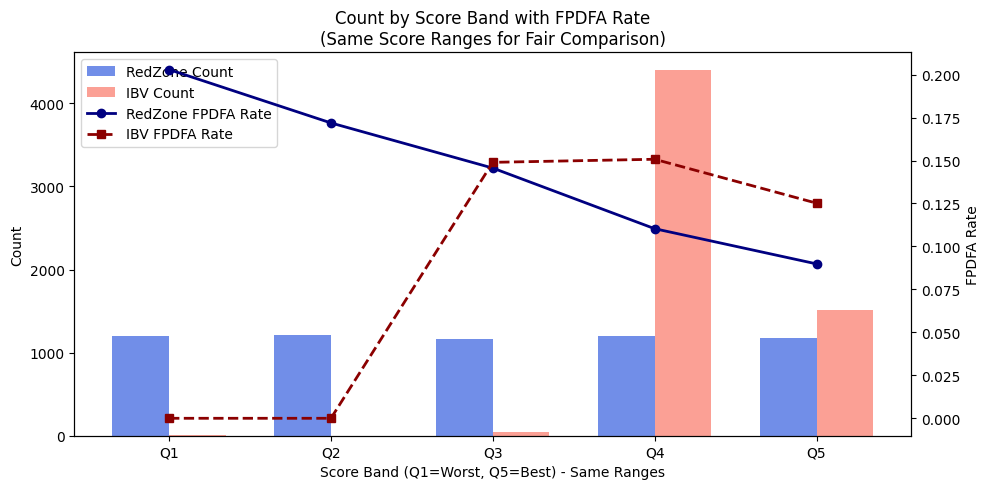

(   Band  AvgPayin  # Loans  Count Pct (%)  # IsGood  IsGood Rate (%)  # FPDFA  \
 0     1  1.551462        3       0.050336       3.0       100.000000      0.0   
 1     2  0.000000        0            0.0       0.0         0.000000      0.0   
 2     3  1.208727       49       0.822148      35.0        71.428571      7.0   
 3     4  0.913099     4397      73.775168    2126.0        48.351149    613.0   
 4     5  0.990544     1511      25.352349     810.0        53.606883    179.0   
 
    FPDFA Rate (%)  
 0        0.000000  
 1        0.000000  
 2       14.893617  
 3       15.072535  
 4       12.517483  ,
    Band  AvgPayin  # Loans  Count Pct (%)  # IsGood  IsGood Rate (%)  # FPDFA  \
 0     1  0.897751     1195      20.050336     567.0        47.447699    223.0   
 1     2  0.911270     1213      20.352349     590.0        48.639736    193.0   
 2     3  0.935460     1170      19.630872     584.0        49.914530    160.0   
 3     4  0.945759     1204      20.201342     602.

In [12]:
# --- Plot: counts (bars) + FPDFA rate (lines) by 5 bands (same as rerun_analysis_V0) ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def build_perf_base(df):
    d = df.copy()

    # normalize
    for c in ["AppID", "PortfolioID", "IBVStatusID"]:
        if c in d.columns:
            d[c] = pd.to_numeric(d[c], errors="coerce").astype("Int64")

    for c in ["Originated", "IBVScore", "redZoneV2_score", "Payin", "IsGood", "FPDFA", "is_loan_first_install"]:
        if c in d.columns:
            d[c] = pd.to_numeric(d[c], errors="coerce")

    mask = (
        d["AppID"].notna()
        & d["PortfolioID"].notna()
        & (d["Originated"].fillna(0).astype(int) == 1)
        & d["IBVScore"].notna()
        & d["redZoneV2_score"].notna()
    )
    return d.loc[mask].copy()

def ibv_band_fn(x):
    if pd.isna(x):
        return pd.NA
    if x < 452:
        return 1
    if x < 621:
        return 2
    if x < 700:
        return 3
    if x < 753:
        return 4
    return 5

def summarize_by_band(df: pd.DataFrame, band_col: str) -> pd.DataFrame:
    df_local = df.dropna(subset=[band_col]).copy()
    if len(df_local) == 0:
        return pd.DataFrame(columns=[
            "Band", "AvgPayin", "# Loans", "Count Pct (%)",
            "# IsGood", "IsGood Rate (%)", "# FPDFA", "FPDFA Rate (%)",
        ])

    agg = (
        df_local.groupby(band_col)
        .agg(
            AvgPayin=("Payin", "mean"),
            Loans=("IBVStatusID", "count"),
            IsGoodCnt=("IsGood", "sum"),
            IsGoodRate=("IsGood", "mean"),
            FPDFACnt=("FPDFA", "sum"),
            FPDFA_denom=("is_loan_first_install", "sum"),
        )
        .reset_index()
        .rename(columns={band_col: "Band", "Loans": "# Loans"})
    )

    total = float(agg["# Loans"].sum())
    agg["Count Pct (%)"] = (agg["# Loans"] / total) * 100.0
    agg["IsGood Rate (%)"] = agg["IsGoodRate"] * 100.0
    agg["FPDFA Rate (%)"] = (agg["FPDFACnt"] / agg["FPDFA_denom"].replace({0: np.nan})) * 100.0

    out = agg[[
        "Band", "AvgPayin", "# Loans", "Count Pct (%)",
        "IsGoodCnt", "IsGood Rate (%)", "FPDFACnt", "FPDFA Rate (%)",
    ]].rename(columns={"IsGoodCnt": "# IsGood", "FPDFACnt": "# FPDFA"})

    return out.sort_values("Band").reset_index(drop=True)

def fill_missing_bands(tbl: pd.DataFrame, bands=range(1, 6)) -> pd.DataFrame:
    t = tbl.copy()
    if len(t) == 0:
        t = pd.DataFrame({"Band": list(bands)})
    else:
        t["Band"] = pd.to_numeric(t["Band"], errors="coerce").astype("Int64")
        t = t.set_index("Band").reindex(list(bands)).reset_index()

    for c in t.columns:
        if c != "Band":
            t[c] = pd.to_numeric(t[c], errors="coerce").fillna(0)
    return t

# Build originated perf base
base = build_perf_base(df_perf_merged)
print("base rows used for band perf chart:", len(base))

# Banding
base["IBVBandV2"] = base["IBVScore"].apply(ibv_band_fn).astype("Int64")
base["RedZoneBand5"] = pd.qcut(
    base["redZoneV2_score"],
    q=5,
    labels=[1, 2, 3, 4, 5],
    duplicates="drop",
).astype("Int64")

# Tables
ibv_table5 = summarize_by_band(base, "IBVBandV2")
redzone_table5 = summarize_by_band(base, "RedZoneBand5")

ibv5 = fill_missing_bands(ibv_table5)
rz5 = fill_missing_bands(redzone_table5)

# Plot (same style as V0)
labels = [f"Q{i}" for i in range(1, 6)]
x = np.arange(len(labels))
w = 0.35

fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.bar(x - w/2, rz5["# Loans"], width=w, label="RedZone Count", color="royalblue", alpha=0.75)
ax1.bar(x + w/2, ibv5["# Loans"], width=w, label="IBV Count", color="salmon", alpha=0.75)
ax1.set_xticks(x)
ax1.set_xticklabels(labels)
ax1.set_xlabel("Score Band (Q1=Worst, Q5=Best) - Same Ranges")
ax1.set_ylabel("Count")

ax2 = ax1.twinx()
ax2.plot(x, rz5["FPDFA Rate (%)"] / 100.0, marker="o", linewidth=2, label="RedZone FPDFA Rate", color="navy")
ax2.plot(x, ibv5["FPDFA Rate (%)"] / 100.0, marker="s", linewidth=2, linestyle="--", label="IBV FPDFA Rate", color="darkred")
ax2.set_ylabel("FPDFA Rate")

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, loc="upper left")

plt.title("Count by Score Band with FPDFA Rate\n(Same Score Ranges for Fair Comparison)")
plt.tight_layout()
plt.show()

ibv5, rz5

### Swap analysis (scenario-based)
We’ll start with a **5-band (quintile) RedZone** design and use the **Q3 cutoff** (boundary between band 3 and band 4, i.e. 60th percentile) as the “good” threshold.

- **Swap-in**: low IBV band (1–2) but high RedZone (band 4–5)
- **Swap-out**: high IBV band (4–5) but low RedZone (band 1–3)



In [13]:

# Base for swap analysis: needs both scores
swap_base = df_perf_merged.dropna(subset=["redZoneV2_score"]).copy()

# Ensure numeric
swap_base["redZoneV2_score"] = pd.to_numeric(swap_base["redZoneV2_score"], errors="coerce")
swap_base["IBVScore"] = pd.to_numeric(swap_base["IBVScore"], errors="coerce")

# 1) RedZone 5-bandC quintile bands + cutoffs
rz_quantiles = swap_base["redZoneV2_score"].dropna().quantile([0.2, 0.4, 0.6, 0.8])
rz_cut_q3 = float(rz_quantiles.loc[0.6])
print("RedZone quintile cutoffs (20/40/60/80%):")
print(rz_quantiles)
print("\nQ3 cutoff (band3->band4 boundary):", rz_cut_q3)

swap_base["RedZoneBand5"] = pd.qcut(
    swap_base["redZoneV2_score"],
    q=5,
    labels=[1, 2, 3, 4, 5],
    duplicates="drop",
).astype("Int64")

# 2) IBV bands
# Prefer the existing IBVBand column when present; otherwise compute from IBVScore.
if "IBVBand" in swap_base.columns:
    swap_base["IBVBand_existing"] = pd.to_numeric(swap_base["IBVBand"], errors="coerce").astype("Int64")
else:
    swap_base["IBVBand_existing"] = pd.NA

# Manual banding (matches rerun_analysis_V0 cutoffs)
def ibv_band_fn(x):
    if pd.isna(x):
        return pd.NA
    if x < 452:
        return 1
    if x < 621:
        return 2
    if x < 700:
        return 3
    if x < 753:
        return 4
    return 5

swap_base["IBVBand_manual"] = swap_base["IBVScore"].apply(ibv_band_fn).astype("Int64")

# Choose which IBV band definition to use for swap logic
# (manual is safest/explicit; existing sometimes has a 0 category)
ibv_band_col = "IBVBand_manual"

# 3) Define swap-in / swap-out (scenario: cutoff at RedZone band 3)
rz_high = swap_base["RedZoneBand5"].isin([4, 5])
rz_low = swap_base["RedZoneBand5"].isin([1, 2, 3])

ibv_low = swap_base[ibv_band_col].isin([1, 2])
ibv_high = swap_base[ibv_band_col].isin([4, 5])

swap_in_mask = ibv_low & rz_high
swap_out_mask = ibv_high & rz_low

print("\nCounts:")
print("Total rows (swap_base):", len(swap_base))
print("Swap-in candidates:", int(swap_in_mask.sum()))
print("Swap-out candidates:", int(swap_out_mask.sum()))

# 4) Summaries (uses what exists; Accepted/Originated are present in V1)
def summarize_segment(df: pd.DataFrame, name: str) -> dict:
    out = {"segment": name, "n": len(df)}
    if len(df) == 0:
        return out

    for col in ["Accepted", "Originated"]:
        if col in df.columns:
            out[f"{col}_rate"] = pd.to_numeric(df[col], errors="coerce").mean()

    out["IBVScore_mean"] = pd.to_numeric(df["IBVScore"], errors="coerce").mean()
    out["RedZone_mean"] = pd.to_numeric(df["redZoneV2_score"], errors="coerce").mean()
    out["RedZone_median"] = pd.to_numeric(df["redZoneV2_score"], errors="coerce").median()
    return out

segments = pd.DataFrame([
    summarize_segment(swap_base, "All"),
    summarize_segment(swap_base.loc[ibv_low], "IBV low (bands 1-2)"),
    summarize_segment(swap_base.loc[ibv_high], "IBV high (bands 4-5)"),
    summarize_segment(swap_base.loc[rz_low], "RedZone low (bands 1-3)"),
    summarize_segment(swap_base.loc[rz_high], "RedZone high (bands 4-5)"),
    summarize_segment(swap_base.loc[swap_in_mask], "Swap-in"),
    summarize_segment(swap_base.loc[swap_out_mask], "Swap-out"),
])

segments


RedZone quintile cutoffs (20/40/60/80%):
0.2    132.0
0.4    165.0
0.6    204.0
0.8    257.0
Name: redZoneV2_score, dtype: float64

Q3 cutoff (band3->band4 boundary): 204.0

Counts:
Total rows (swap_base): 21902
Swap-in candidates: 96
Swap-out candidates: 7404


,segment,n,Originated_rate,IBVScore_mean,RedZone_mean,RedZone_median
0,All,21902,0.289398,710.448470,193.248445,183.0
1,IBV low (bands 1-2),843,0.003559,442.144721,138.989429,139.0
2,IBV high (bands 4-5),14353,0.411621,738.384589,210.190812,202.0
3,RedZone low (bands 1-3),13177,0.234034,697.453687,142.419860,146.0
4,RedZone high (bands 4-5),8725,0.371539,728.651850,270.012718,257.0
5,Swap-in,96,0.000000,266.979167,257.895833,248.0
6,Swap-out,7404,0.385873,735.328606,151.595517,157.0


In [14]:
# Scenario variant: use RedZone cutoff at band2 (given cutoff score = 173)
rz_cut_b2 = 173.0

# (optional) compare to the empirical 40th percentile cutoff
try:
    rz_cut_p40 = float(swap_base["redZoneV2_score"].dropna().quantile(0.4))
    print("RedZone 40th percentile cutoff:", rz_cut_p40)
except Exception as e:
    print("Could not compute 40th percentile cutoff:", e)

print("Using band2 cutoff score:", rz_cut_b2)

rz_high_b2 = swap_base["redZoneV2_score"] > rz_cut_b2   # bands 3-5
rz_low_b2 = swap_base["redZoneV2_score"] <= rz_cut_b2   # bands 1-2

swap_in_mask_b2 = ibv_low & rz_high_b2
swap_out_mask_b2 = ibv_high & rz_low_b2

print("\nCounts (band2 cutoff):")
print("Total rows (swap_base):", len(swap_base))
print("Swap-in candidates:", int(swap_in_mask_b2.sum()))
print("Swap-out candidates:", int(swap_out_mask_b2.sum()))

segments_b2 = pd.DataFrame([
    summarize_segment(swap_base, "All"),
    summarize_segment(swap_base.loc[ibv_low], "IBV low (bands 1-2)"),
    summarize_segment(swap_base.loc[ibv_high], "IBV high (bands 4-5)"),
    summarize_segment(swap_base.loc[rz_low_b2], "RedZone low (<= band2 cutoff)"),
    summarize_segment(swap_base.loc[rz_high_b2], "RedZone high (> band2 cutoff)"),
    summarize_segment(swap_base.loc[swap_in_mask_b2], "Swap-in (band2 cutoff)"),
    summarize_segment(swap_base.loc[swap_out_mask_b2], "Swap-out (band2 cutoff)"),
])

segments_b2


RedZone 40th percentile cutoff: 165.0
Using band2 cutoff score: 173.0

Counts (band2 cutoff):
Total rows (swap_base): 21902
Swap-in candidates: 173
Swap-out candidates: 5102


,segment,n,Originated_rate,IBVScore_mean,RedZone_mean,RedZone_median
0,All,21902,0.289398,710.448470,193.248445,183.0
1,IBV low (bands 1-2),843,0.003559,442.144721,138.989429,139.0
2,IBV high (bands 4-5),14353,0.411621,738.384589,210.190812,202.0
3,RedZone low (<= band2 cutoff),9853,0.207781,690.641900,126.796714,137.0
4,RedZone high (> band2 cutoff),12049,0.355124,725.475814,247.588964,236.0
5,Swap-in (band2 cutoff),173,0.000000,331.306358,227.611928,210.0
6,Swap-out (band2 cutoff),5102,0.371227,734.045276,134.822088,143.0
